# Red Giant Mode fitting

Fitting RG stars chosen at random.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
import random

In [3]:
# Use ID to choose star
# import data
output = pd.read_csv('RGdata/output_1000stars.csv', delim_whitespace=False, header=0, usecols=range(1,4))
#ID = random.choice(output['ID'])
ID = 3323943
star = output.loc[(output['ID'] == ID)]
star

,ID,Numax,Numax_err
826,3323943,32.077039,1.140758


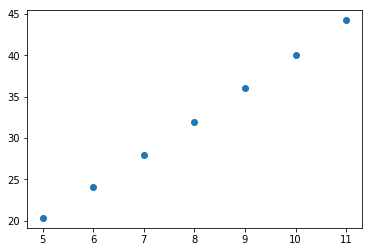

In [4]:
#import output data
modes = pd.read_csv('RGdata/modes_'+str(ID)+'.csv', delim_whitespace=False, header=0, usecols=['f0', 'f0_err'])
modes = modes.sort_values(by=['f0'])
modes = modes.set_index(np.arange(0,len(modes),1))
modes['dnu'] = (modes['f0'].diff(2).shift(-1))/2
dnu_avg = np.mean(modes['dnu'])
n_min = int(modes.f0.min() / dnu_avg)
n_obs = np.arange(n_min, n_min+len(modes.f0), 1)
modes.insert(loc=0, column='n', value=n_obs)
modes
plt.scatter(modes.n, modes.f0)

To find a ballpark figure before defining priors, will use model:

$$\nu(n)=(n+\epsilon)\langle\Delta\nu\rangle+k(n_{max}-n)^2+\mathcal{A}e^{-n/\tau}sin(nw+\phi)$$

where $n_{max}= \nu_{max}/\Delta\nu - \epsilon$

In [5]:
def model(n, dnu, nmax, epsilon, k, A, w, tau, phi):
    freqs = (n + epsilon) * dnu + k * (nmax - n)**2 + A * np.exp(-n/tau) * np.sin(n * w + phi);
    return freqs

In [6]:
n = modes.n
numax_obs = star.iloc[0]['Numax']
epsilon = 1.20
nmax = numax_obs/dnu_avg - epsilon
k = 0.06
A = 0.3
w = 2.0
tau = 10
phi = 0
f = model(n, dnu_avg, nmax, epsilon, k, A, w, tau, phi)

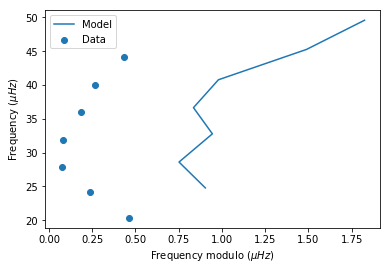

In [7]:
plt.scatter(modes.f0 % dnu_avg, modes.f0, label = 'Data') 
plt.plot(f % dnu_avg, f, label = 'Model')
plt.xlabel(r'Frequency modulo ($\mu Hz$)')
plt.ylabel(r'Frequency ($\mu Hz$)')
plt.legend()

In [155]:
code = '''
data {
    int N;
    real n[N];
    real freq[N];
    real freq_err[N];
    real dnu_guess;
    real numax;
}
parameters {   
    real dnu;
    real epsilon;
    real<lower = 0> nmax;
    real k;
    real<lower = 0> A;
    real<lower = 0> w;
    real<lower = -pi(), upper = pi()> phi;
    real<lower = 0> tau;
}
model {
    real mod[N];
    for (i in 1:N){
        mod[i] = (n[i] + epsilon) * dnu + k * (nmax - n[i])^2 + 
            A * exp(-n[i]/tau) * sin(n[i] * w + phi);
    }
    mod ~ normal(freq, freq_err);
    dnu ~ normal(dnu_guess, dnu_guess*0.001);
    epsilon ~ normal(1.2, 0.50);
    epsilon ~ uniform(-1, 2);
    //epsilon ~ normal(numax/dnu - nmax, 0.50);
    nmax ~ normal(7, 2);
    k ~ lognormal(log(0.06), 0.02);
    A ~ lognormal(log(0.8), 0.5);
    w ~ normal(2, 0.8);
    tau ~ normal(2.0, 0.6);
}
'''
import pystan
sm = pystan.StanModel(model_code=code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_a2c8b3d154c745c47184a02d20aed6d8 NOW.
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2_/b8v0t8pn1hj1p3r4lyfvvv2h0000gn/T/tmp16mlhxy_/stanfit4anon_model_a2c8b3d154c745c47184a02d20aed6d8_2035972461384721212.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [156]:
data = {'N': len(modes.f0), 'freq': modes.f0, 'freq_err': modes.f0_err, 
        'dnu_guess': dnu_avg, 'n': modes.n, 'numax': numax_obs}
start = {'dnu': 2.00, 'epsilon': 0.03, 'nmax': nmax, 'k': 0.05, 'A': 0.8, 'w': 0.8, 'phi': -0.9*np.pi, 'tau': 1}
nchains=4
fit = sm.sampling(data=data, iter=5000, chains=nchains, init=[start for n in range(nchains)])

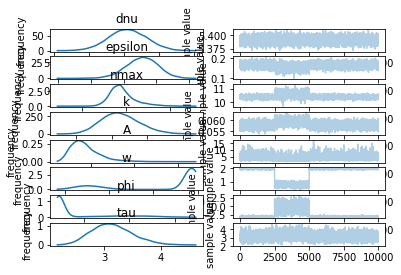

In [157]:
fit.plot()
plt.show()

In [158]:
print(fit)

Inference for Stan model: anon_model_a2c8b3d154c745c47184a02d20aed6d8.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dnu       5.39  7.8e-5 5.4e-3   5.38   5.39   5.39   5.39    5.4   4859    1.0
epsilon   0.16  3.0e-3   0.01   0.14   0.16   0.16   0.17   0.19     17   1.08
nmax     10.46    0.06   0.15  10.23  10.36  10.43  10.52  10.82      6   1.24
k         0.06  5.7e-4 1.3e-3   0.06   0.06   0.06   0.06   0.06      6   1.23
A         4.37    0.25   1.66   2.04   3.22   4.07   5.19   8.51     45   1.04
w         1.64    0.36   0.51   0.61   1.44   1.93   1.94   1.96      2    8.1
phi      -2.35    0.88   1.37  -3.14  -3.11  -3.05  -2.71   1.29      2   2.39
tau       3.14    0.06   0.36   2.51   2.89   3.12   3.37   3.92     37   1.04
lp__    -51.44    4.33    6.4 -64.77 -58.31 -48.53 -46.83 -45.05      2   3.32

Samples were drawn 

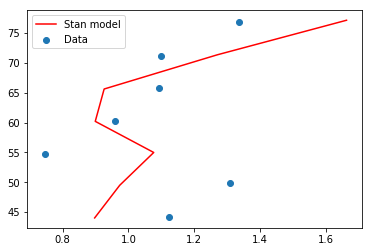

In [159]:
stanfit = model(modes.n, fit['dnu'].mean(), fit['nmax'].mean(), fit['epsilon'].mean(), fit['k'].mean(), fit['A'].mean(), fit['w'].mean(), fit['tau'].mean(), fit['phi'].mean())

plt.subplots()
plt.scatter(modes.f0 % dnu_avg, modes.f0, label = 'Data')
plt.plot(stanfit % fit['dnu'].mean(), stanfit, label = 'Stan model', color = 'r')
plt.legend()

In [160]:
yn = input("Would you like to save this data to .csv? (y/n) ")
if yn == str('y'):
    output = pd.DataFrame({'dnu': fit['dnu'], 'nmax': fit['nmax'], 'epsilon': fit['epsilon'], 
                           'k': fit['k'], 'A': fit['A'], 'w': fit['w'], 'phi': fit['phi'],
                           'tau': fit['tau']})
    output.to_csv('samples_' + str(ID) + '.csv')
    
elif yn == str('n'):
    print('cool beans')
else:
    print('Please try again')

Would you like to save this data to .csv? (y/n) n
cool beans


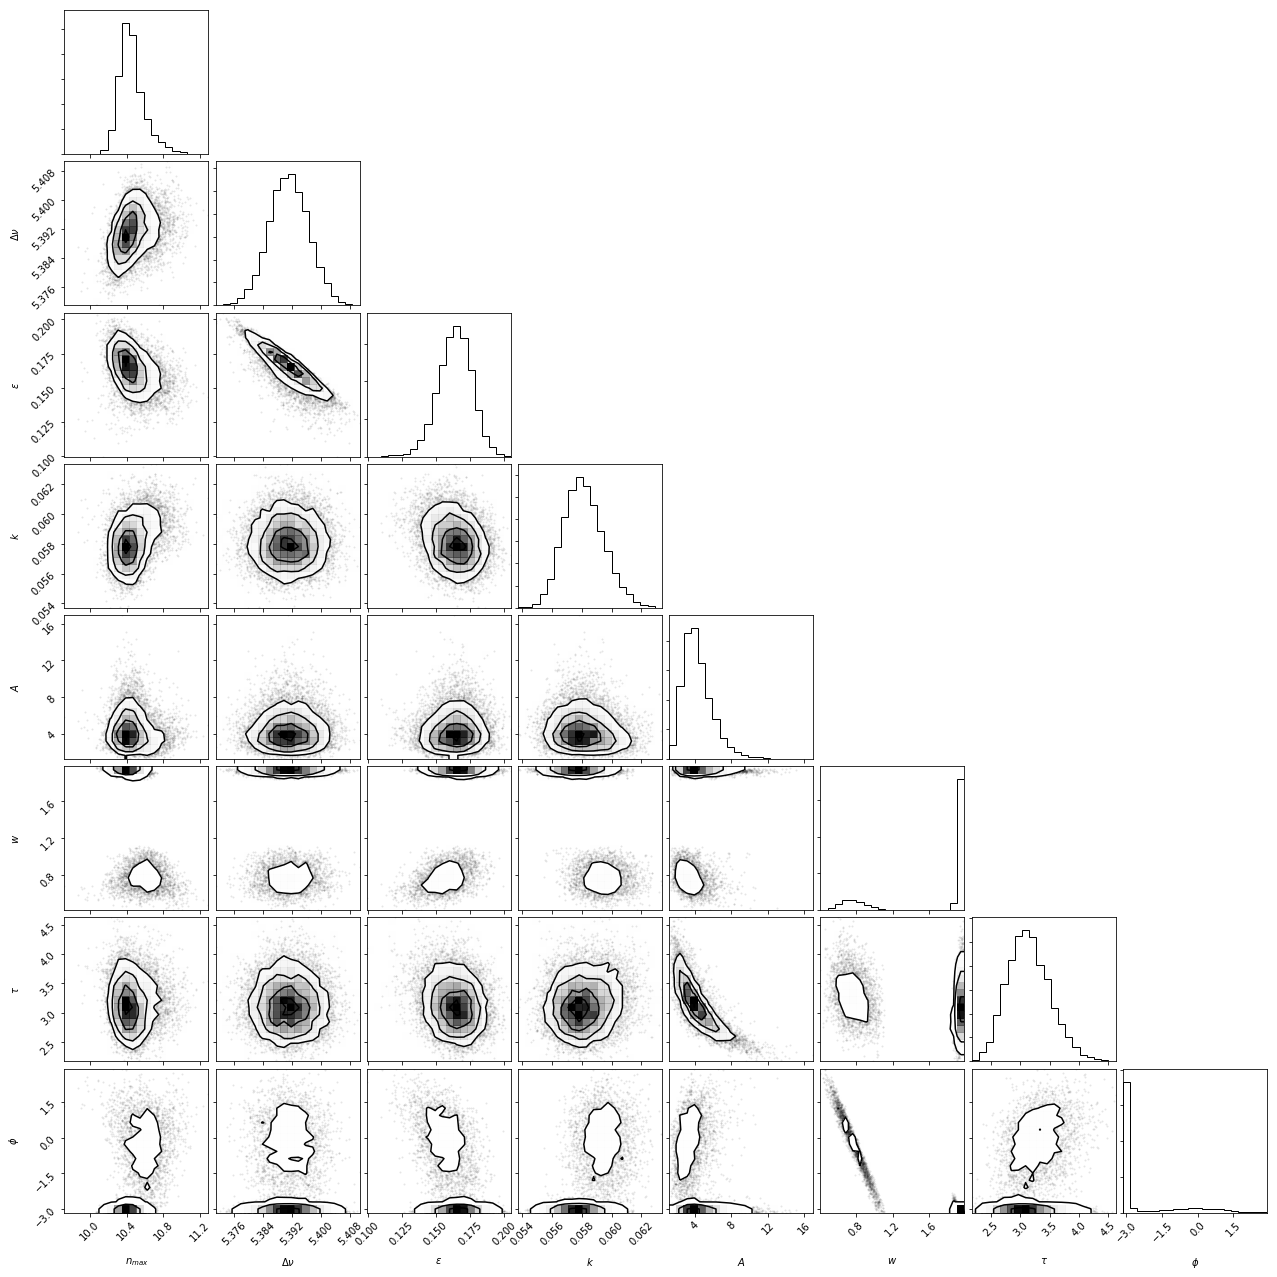

In [161]:
import corner
data = np.vstack([fit['nmax'], fit['dnu'], fit['epsilon'], fit['k'], fit['A'], fit['w'], fit['tau'], fit['phi'],]).T
corner.corner(data, labels=[r'$n_{max}$', r'$\Delta\nu$', r'$\epsilon$', r'$k$', r'$A$', r'$w$', r'$\tau$', r'$\phi$'])
plt.show()